In [438]:
import matplotlib.pyplot as plt
import cirq
import numpy as np
from cirq.contrib.svg import SVGCircuit
import sympy as sp
import pandas as pd
import math
import cma

## 1. Initialization : Crystal weight matrix

In [439]:
# Constant Block

s = 1/np.sqrt(2)

# Mode Block, mode = 1 Cobyla, mode = 2 Cma-Es, mode = 3 grid method

p = 1
mode = 2
grid_size = 11

# Weight Block

weight = np.array([
    [0, 1, 1, s, 0, -1, -1, -s],
    [0, 0, s, 1, -1, 0, -s, -1],
    [0, 0, 10, 1, -1, -s, 0, -1],
    [0, 0, 0, 10, -s, -1, -1, 0],
    [0, 0, 0, 0, 10, 1, 1, s],
    [0, 0, 0, 0, 0, 10, s, 1],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

print(weight)


[[ 0.          1.          1.          0.70710678  0.         -1.
  -1.         -0.70710678]
 [ 0.          0.          0.70710678  1.         -1.          0.
  -0.70710678 -1.        ]
 [ 0.          0.         10.          1.         -1.         -0.70710678
   0.         -1.        ]
 [ 0.          0.          0.         10.         -0.70710678 -1.
  -1.          0.        ]
 [ 0.          0.          0.          0.         10.          1.
   1.          0.70710678]
 [ 0.          0.          0.          0.          0.         10.
   0.70710678  1.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]


In [440]:
node = weight.shape[0]
print(node)
qaoa_circuit = cirq.Circuit()

def qaoa_drawer(weight, symbols, i, node):
    gamma = sp.Symbol(symbols[0][i])
    beta = sp.Symbol(symbols[1][i])

    qubits = cirq.LineQubit.range(node)

    def cirqzz(qubits, weight, i, j):
        return [cirq.CNOT(qubits[i], qubits[j]), cirq.rz(2 * gamma * weight[i, j]/4)(qubits[j]), cirq.CNOT(qubits[i], qubits[j])]
    
    for i in range(node):
        for j in range(i+1, node):
            if weight[i, j] != 0:
                qaoa_circuit.append(cirqzz(qubits, weight, i, j))
                qaoa_circuit.append(cirq.rz(2 * gamma * weight[i, j]/2)(qubits[i]))
                qaoa_circuit.append(cirq.rz(2 * gamma * weight[i, j]/2)(qubits[j]))
                # qaoa_circuit.append(cirq.ZZ(qubits[i], qubits[j]) ** (2 * gamma * weight[i, j]))

    # Self Ineraction term
    for i in range(node):
        if weight[i, i] != 0:
            qaoa_circuit.append(cirq.rz(2 * gamma * weight[i, i] * 1/2)(qubits[i]))
            
    # Mixer layer (Rx rotations applied in parallel)
    qaoa_circuit.append([cirq.rx(2 * beta)(q) for q in qubits])

def qaoa_depth(weight, p, node):
    qubits = cirq.LineQubit.range(node)
    symbols = [["γ" + f"{i}" for i in range(p)], ["β" + f"{i}" for i in range(p)]]
    qaoa_circuit.append([cirq.H(q) for q in qubits])
    
    for i in range(p):
        qaoa_drawer(weight, symbols, i, node)

    # Measurement layer
    qaoa_circuit.append([cirq.measure(q) for q in qubits])

8


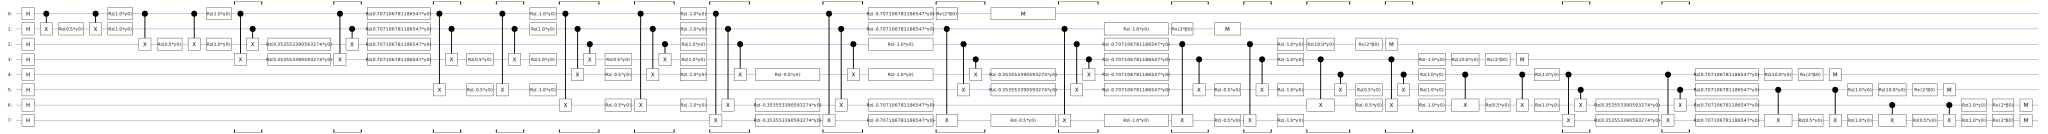

In [441]:
qaoa_depth(weight, p, node)
SVGCircuit(qaoa_circuit)

## 2. Cost Function Calculation and Simulation over beta and gamma

In [442]:
def estimate_cost(weight, samples):
    cost_value = 0.0
    node = weight.shape[0]

    # Loop over upper triangle of adjacency matrix
    for i in range(node):
        for j in range(i+1, node):
            if weight[i, j] != 0:
                i_samples = samples["q(" + str(i) + ")"]
                j_samples = samples["q(" + str(j) + ")"]

                # Convert {0,1} to {-1, +1}
                i_signs = (-1) ** (i_samples + 1) 
                j_signs = (-1) ** (j_samples + 1)
                term_signs = i_signs * j_signs

                # Expectation value for edge (i,j)
                term_val = np.mean(term_signs) * weight[i, j]/4
                i_value = np.mean(i_signs) * weight[i, j]/2
                j_value = np.mean(j_signs) * weight[i, j]/2
                cost_value += term_val + i_value + j_value

    # loop over diagonal element of weight matrix
    for i in range(node):
        if weight[i, i] != 0:
            i_samples = samples["q(" + str(i) + ")"]

            # Convert {0,1} to {-1, +1}
            i_signs = (-1) ** (i_samples+1)
            term_val = np.mean(i_signs) * weight[i, i]/2
            cost_value += term_val

    return cost_value

In [443]:
import time
from scipy.optimize import minimize

start = time.time()

def qaoa_cost(params, weight, p, node, repetitions=5000):
    param_dict = {}
    for i in range(p):
        param_dict[f"γ{i}"] = params[2 * i]
        param_dict[f"β{i}"] = params[2 * i + 1]

    qubits = cirq.LineQubit.range(node)
    circuit = cirq.Circuit()
    global qaoa_circuit
    qaoa_circuit = cirq.Circuit()  # reset before building
    qaoa_depth(weight, p, node)
    circuit += qaoa_circuit

    sim = cirq.Simulator()
    results = sim.sample(circuit, params=param_dict, repetitions=repetitions)
    results = dict(results)
    return estimate_cost(weight, results)

# MAX Value Finder
def neg_qaoa_cost(params, weight, p, node):
    return -qaoa_cost(params, weight, p, node)

def p1_case(grid_size, gamma_sweep, beta_sweep):
    
    grid = np.zeros((grid_size, grid_size))
    sim = cirq.Simulator()
    
    for i in range(grid_size):
        for j in range(grid_size):
            results = sim.sample(qaoa_circuit, params = {"γ0" : gamma_sweep[i], "β0" : beta_sweep[j]}, repetitions = 20000)
            results = dict(results)
            cost = estimate_cost(weight, results)
            grid[i, j] = cost
    
    mini, maxi = np.min(grid), np.max(grid)
    min_g, min_b = np.unravel_index(np.argmin(grid), grid.shape)
    min_gam = gamma_sweep[min_g] 
    min_bet = beta_sweep[min_b]
    return mini, maxi, min_gam, min_bet, grid

In [ ]:
if mode == 1:
    initial_params = np.random.uniform(0, np.pi, size=2 * p)
    res = minimize(
        qaoa_cost,
        x0=initial_params,
        args=(weight, p, node),
        method='COBYLA',
        options={'maxiter': 1000, 'disp': True}
    )

    optimal_params = res.x
    min_gam = [optimal_params[2 * i] for i in range(p)]
    min_bet = [optimal_params[2 * i + 1] for i in range(p)]

    print("Optimal gamma:", np.round(min_gam, 3))
    print("Optimal beta:", np.round(min_bet, 3))

    end = time.time()
    period = end - start
    print(f"The elapsed time is {period}")

elif mode == 2:
    x0 = np.random.uniform(0, np.pi, size=2 * p)
    sigma0 = 0.5  # Step size

    # Call CMA-ES optimizer
    res = cma.fmin(
        qaoa_cost,
        x0,
        sigma0,
        args=(weight, p, node),
        options={
            "maxfevals": 10000,     # Max number of cost evaluations
            "verb_disp": 1         # Show progress
        }
    )

    best_params = res[5]  # Optimal gamma and beta values
    min_gam = best_params[:p]
    min_bet = best_params[p:]

    print("Optimal gamma:", np.round(min_gam, 3))
    print("Optimal beta:", np.round(min_bet, 3))

    end = time.time()
    period = end - start
    print(f"The elapsed time is {period}")

elif mode == 3:
    def gam_beta_grid(weight, grid_size, p):
        grid = np.zeros((grid_size, grid_size))
        gamma_sweep = np.linspace(0, np.pi, grid_size)
        print(gamma_sweep)
        beta_sweep = np.linspace(0, np.pi, grid_size)
        print(beta_sweep)

        if p == 1:
            mini, maxi, min_gam, min_bet, grid = p1_case(grid_size, gamma_sweep, beta_sweep)
            return mini, maxi, min_gam, min_bet, grid

        if p == 2:
            mini, maxi, min_gam, min_bet, grid = p2_case(grid_size, gamma_sweep, beta_sweep)
            return mini, maxi, min_gam, min_bet, grid

        if p == 3:
            mini, maxi, min_gam, min_bet, grid = p3_case(grid_size, gamma_sweep, beta_sweep)
            return mini, maxi, min_gam, min_bet, grid
    
        
    mini, maxi, min_gam, min_bet, grid = gam_beta_grid(weight, grid_size, p)
    min_gam = [min_gam]
    min_bet = [min_bet]
    print(mini, maxi, min_gam, min_bet)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=488737, Wed May 28 23:52:02 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -4.339102352006586e+00 1.0e+00 4.64e-01  4e-01  5e-01 0:00.5
    2     12 -9.646335952314143e+00 1.3e+00 5.20e-01  4e-01  6e-01 0:01.1
    3     18 -9.300955880016465e+00 1.6e+00 4.50e-01  3e-01  5e-01 0:01.6
    4     24 -1.960042403999693e+01 1.7e+00 4.76e-01  3e-01  6e-01 0:02.1
    5     30 -3.478527207793864e+00 2.0e+00 5.08e-01  3e-01  6e-01 0:02.6
    6     36 -8.470067027304760e+00 1.7e+00 4.40e-01  2e-01  5e-01 0:03.1
    7     42 -1.110851067811866e+01 2.1e+00 3.33e-01  2e-01  3e-01 0:03.6
    8     48 -8.901533513652378e+00 2.0e+00 2.91e-01  1e-01  3e-01 0:04.1
    9     54 -7.664720310216783e+00 2.0e+00 2.32e-01  9e-02  2e-01 0:04.6


In [ ]:
if mode == 1:
    pass
if mode == 2:
    
    print(res)
    best_params = res[5]  # Optimal gamma and beta values
    min_gam = best_params[:p]
    min_bet = best_params[p:]

    print("Optimal gamma:", np.round(min_gam, 3))
    print("Optimal beta:", np.round(min_bet, 3))

    end = time.time()
    period = end - start
    print(f"The elapsed time is {period}")

## 3. Simulation over optimized gamma and beta

In [ ]:
def simulate_opti(qaoa_circuit, min_gam, min_bet, weight, p):
    
    params = {}
    for i in range(p):
        params[f"γ{i}"] = min_gam[i]
        params[f"β{i}"] = min_bet[i]

    sim = cirq.Simulator()
    sample_results = sim.sample(qaoa_circuit, params=params, repetitions=200000)
    sample_results = dict(sample_results)

    print(f"Gamma = {np.round(min_gam, 3)}")
    print(f"Beta  = {np.round(min_bet, 3)}")
    print(f"Estimated cost: {estimate_cost(weight, sample_results)}")
    
    return sample_results


In [ ]:
sample_results = simulate_opti(qaoa_circuit, min_gam, min_bet, weight, p)

In [ ]:
def histogram_qubits(result, node, repetition):
    qubit_list = {}
    str_qubit = ["q(" + str(i) + ")" for i in range(node)]
    for idx in range(repetition):
        res_qubit = ""
        for jdx in str_qubit:
            res_qubit += str(result[jdx][idx])

        try:
            qubit_list[res_qubit] += 1
        except:
            qubit_list[res_qubit] = 1

    return qubit_list

In [ ]:
qubit_list = histogram_qubits(sample_results, node, 200000)
sorted_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[0]))
sorted_qubit_list = {int(k, 2): v for k, v in sorted_qubit_list.items()}
ranking_qubit_list = dict(sorted(qubit_list.items(), key=lambda x: x[1], reverse=True))
# print(ranking_qubit_list)
compo = list(ranking_qubit_list.keys())
count = list(ranking_qubit_list.values())


In [ ]:
print("All List")
    
for i in range(int (len(compo) / node)):
    print(compo[i], " : ", count[i]) 
# print(compo[0:100], count[0:100])

sym = sorted_qubit_list.keys()
val = sorted_qubit_list.values()
top_N = 100
top_keys = list(ranking_qubit_list.keys())[:top_N]
top_vals = list(ranking_qubit_list.values())[:top_N]
top_keys_int = [int(k, 2) for k in top_keys]

plt.bar(top_keys_int, top_vals, color="pink")
plt.title("Top QAOA States")
plt.xlabel("Bitstring (int)")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig("Nyx.png")
plt.show()